# COIN-TOLIMAN Simulations 3.0
---
Added complexites:
- More accurate spectra
- Jitter and telescope rotation
- Imperfect diffraction at non-ideal wavelengths
- Defocus, Coma, Astigmatism and Trefoil (or any arbitrary Zernike term)


In [1]:
import sys
import os
dir_name = os.getcwd().split('/')[-1]
parent_path = os.getcwd()[:-(len(dir_name) + 1)]
sys.path.append(parent_path)
sys.path.append('../Sidelobe_fit/')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
from astropy.io import fits
from scipy.ndimage import zoom
from lib import conversions
from lib import formatter
from new_sims import functions
from poppy_model import supergaussian
import pysynphot as S

In [3]:
# Make a filter
central_wav = 550e-9 # angstroms
width = 115e-9 # angstroms
n_wavs = 200

filter_n,filter_sigma = 8,115e-9 # normal
# wavs = np.linspace(central_wav-width/1.5,central_wav+width/1.5,num=n_wavs) # Go a bit past the edges
wavs = np.arange((central_wav-width/1.5)*1e9,1e9*(central_wav+width/1.5),dtype=int) # This program needs the wavs as integers
wavs = wavs.astype(float)*1e-9
wavs_ang = wavs*1e10

throughput = supergaussian(wavs,central_wav,sigma=filter_sigma,n=filter_n)
bandpass = S.ArrayBandpass(wavs_ang, throughput)

Flux ratio: 3.366464997425497


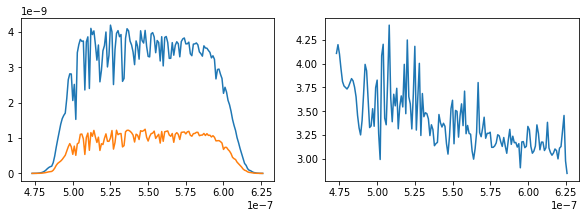

In [4]:
# Make the spectra
acenA_mag = 0.01
acenB_mag = 1.33

# alpha cen A: Teff = 5790, Z = 0.20, log g = 4.30
acenA = S.Icat('phoenix',5790,0.2,4.30)
# alpha cen B: Teff = 5260, Z = 0.23, log g = 4.37
acenB = S.Icat('phoenix',5260,0.23,4.37)
specA_filt = acenA.renorm(acenA_mag, 'vegamag', S.ObsBandpass('johnson,v'))
specB_filt = acenB.renorm(acenB_mag, 'vegamag', S.ObsBandpass('johnson,v'))
acenA_obs = S.Observation(specA_filt, bandpass, binset=wavs_ang)
acenB_obs = S.Observation(specB_filt, bandpass, binset=wavs_ang)

# This gives way too large a wav range
specA2 = acenA_obs.binflux
specB2 = acenB_obs.binflux

# test = acenA_obs.sample()
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(wavs,specA2)
plt.plot(wavs,specB2)
plt.subplot(122)
plt.plot(wavs,specA2/specB2)
print('Flux ratio:',np.sum(specA2)/np.sum(specB2))

# Save it
np.save('new_sims/AcenA_current_sim.npy',specA2)
np.save('new_sims/AcenB_current_sim.npy',specB2)
np.save('new_sims/current_sim_wavelengths.npy',wavs*1e9)

In [5]:
specA = np.load("new_sims/AcenA_cps_1.npy")
specB = np.load("new_sims/AcenB_cps_1.npy")
wavels = np.load("new_sims/Wavelengths.npy")
# specA = np.load('new_sims/AcenA_current_sim.npy')
# specB = np.load('new_sims/AcenB_current_sim.npy')
# wavels = np.load('new_sims/current_sim_wavelengths.npy')
wavels = np.array(wavels, dtype=np.int)
natural_ratio = np.sum(specA)/np.sum(specB)

# Set flux ratio (total flux acenA / total flux acenB)
# To return to the astrophysical flux ratio set flux_ratio = natural_ratio 
diverse_spec = True # If True the two stars spectrums will not be identical
flux_ratio = natural_ratio

if diverse_spec:
    specB = specB*natural_ratio/flux_ratio
else:
    specB = specA/flux_ratio
    
print('Flux ratio:',flux_ratio)

Flux ratio: 3.942665199635808


Following on from our work in Rome we will impose a minimum of three cycles of science signal

In [6]:
# Telescope parameters
aperture = 0.1 # m
m2_obsc = 0 # m
focal_length = 3.65 # 15cm camera lens
npix = 256 # Only simulate central region to decrease computational complexity
pix_size = 6.5e-6 # 1.12 microns
transform_size = 2**10 # 1024 size of the transformed array

# Perfect PSF wavelength (ie 4 times mirror recession depth)
central_wavelength = 595e-9

# For Eduardo
# aperture = 0.08 # m
# m2_obsc = 0 # m
# focal_length = 2.6
# npix = 256 # Only simulate central region to decrease computational complexity
# pix_size = 5.5e-6 # 1.12 microns
# transform_size = 2**10 # 1024 size of the transformed array
# central_wavelength = 550e-9 # Perfect PSF wavelength (ie 4 times mirror recession depth)

sim_name='sims/zernike_both_stars/'

In [7]:
# Science signal paramters
signal_size = 1e-6 # Pixels
signal_size = 0*1e-4 # pixels
signal_cycles = 3

# Astrophysical paramters
separation = 16.5 # Arceseconds
pix_sep = conversions.arcsec_to_pixel(separation, pix_size, focal_length)
pos_A = [0, 0] # Alpha cen A starting positon
pos_B = [pix_sep, 0] # Start with stars aligned along the x axis

# Simulation Paramters
# N = 1200 # Number of images
N = 30 # Number of images

# Random number seed
seed = 0
np.random.seed(seed)

# Jitter paramters
stdev = 0.5 # Pixels

# Rotation Parameters
rotation_scatter = 0.5 # degree, 0.5 is a good number to use
n_rots = 0 # Number of rotations
print('Separation (pix):',pix_sep)

Separation (pix): 44.91985222280278


In [8]:
# Camera parameters
# dark_current = 80
# read_noise = 1.3
# QE = 0.95 # not used
# full_well = 45e3 # not used 
# fps = 10

# Camera parameters
dark_current = 125
read_noise = 13.
QE = 0.46 # not used
full_well = 13.5e3 # not used 
fps = 5

In [9]:
integration_time = 0.5 # Hours 
frame_rate = 10 # Hz

spd = 86400 # Seconds per day
fpd = spd*frame_rate # Frames per day

# Detector noise
dark_noise = read_noise + (dark_current/fps)
# dark_noise = 0

# Photon noise
peak_photons = 30000
peak_photons = 'Default'
# print('Turning dark noise off')

In [10]:
n_cores = 3

--- 
## Define x and y position arrays

Algorithm:
1. Generate science signal as a sinusoid centred around zero
2. Generate rotational signal and impose science signal on radius values
3. Convert to cartesian coordiantes
4. Generate jitters in cartesian coordiantes
5. Combine two sets of cartesian coordiantes

In [11]:
# Science signal
arg = np.linspace(0, signal_cycles*2*np.pi, num=N, endpoint=False)
drs = signal_size*np.sin(arg)

# Write signal file
with open("{}/signal.csv".format(sim_name), 'w') as f:
    f.write("t,x\n")
    for i in range(N):
        f.write("{},{}\n".format(i, drs[i]))

In [12]:
# Generate rotations
phis = np.pi/180*np.random.normal(loc=0,scale=rotation_scatter,size=N)
# phis = np.linspace(0, n_rots*2*np.pi, num=N, endpoint=False)
Xs = np.vstack((pix_sep+drs) * np.cos(phis))
Ys = np.vstack((pix_sep+drs) * np.sin(phis))
coords = np.hstack((Xs, Ys))
with open("{}/rotation.csv".format(sim_name), 'w') as f:
    f.write("t,x\n")
    for i in range(N):
        f.write("{},{}\n".format(i, phis[i]))

In [13]:
# 2D Gaussian with a standard deviation of 0.5 pixels
jitters = np.random.normal(scale=stdev, size=2*N).reshape(N, 2)
with open("{}/jitter.csv".format(sim_name), 'w') as f:
    f.write("t,x\n")
    for i in range(N):
        f.write("{},{},{}\n".format(i, jitters[i,0],jitters[i,1]))

In [14]:
A_coords_xy = jitters
B_coords_xy = coords + jitters

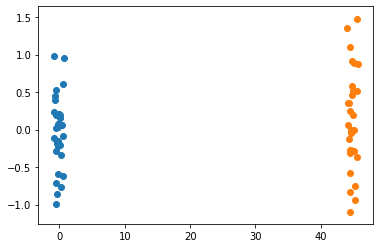

In [15]:
plt.scatter(A_coords_xy[:,0], A_coords_xy[:,1])
plt.scatter(B_coords_xy[:,0], B_coords_xy[:,1])

In [16]:
A_rs = (A_coords_xy[:,0]**2 + A_coords_xy[:,1]**2)**0.5
B_rs = (B_coords_xy[:,0]**2 + B_coords_xy[:,1]**2)**0.5

A_phis = np.arctan2(A_coords_xy[:,1], A_coords_xy[:,0])
B_phis = np.arctan2(B_coords_xy[:,1], B_coords_xy[:,0])

2.2171973492753074


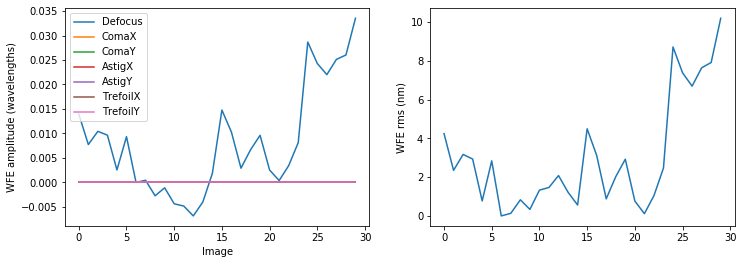

In [17]:
# Wavefront error!
# Generate from a random walk
np.random.seed(seed+2)# +1 so we don't get correlated jitters and defocus

defocus_amount = 0.005 * central_wavelength
coma_amount = 0.000 * central_wavelength
astig_amount = 0.000 * central_wavelength
trefoil_amount = 0.000 * central_wavelength

wfe_rms = np.zeros(N)
defocus_amps = np.zeros(N)
coma_amps = np.zeros((N,2))
astig_amps = np.zeros((N,2))
trefoil_amps = np.zeros((N,2))
last_defocus = 0
last_coma = [0,0]
last_astig = [0,0]
last_trefoil = [0,0]
for ix in range(N):
    next_defocus = np.random.normal(loc=last_defocus,scale=defocus_amount)
    defocus_amps[ix] = next_defocus
    last_defocus = next_defocus
    
    next_coma = np.random.normal(loc=last_coma,scale=coma_amount,size=2)
    coma_amps[ix] = next_coma
    last_coma = next_coma
    
    next_astig = np.random.normal(loc=last_astig,scale=astig_amount,size=2)
    astig_amps[ix] = next_astig
    last_astig = next_astig
    
    next_trefoil = np.random.normal(loc=last_trefoil,scale=trefoil_amount,size=2)
    trefoil_amps[ix] = next_trefoil
    last_trefoil = next_trefoil


# Make a random point zero
defocus_amps -= np.random.choice(defocus_amps)
coma_amps[:,0] -= np.random.choice(coma_amps[:,0])
coma_amps[:,1] -= np.random.choice(coma_amps[:,1])
astig_amps[:,0] -= np.random.choice(astig_amps[:,0])
astig_amps[:,1] -= np.random.choice(astig_amps[:,1])
trefoil_amps[:,0] -= np.random.choice(trefoil_amps[:,0])
trefoil_amps[:,1] -= np.random.choice(trefoil_amps[:,1])


# Measure the RMS WFE on each image
for ix in range(N):
    wfe_terms = {(0,2):defocus_amps[ix],(-1,3):coma_amps[ix,0],(1,3):coma_amps[ix,1],
                      (-2,2):astig_amps[ix,0],(2,2):astig_amps[ix,1],(-3,3):trefoil_amps[ix,0],(3,3):trefoil_amps[ix,0]}
    wfe_map = functions.add_zernikes(wfe_terms,[256,256])
    mean_wfe = np.mean(wfe_map)
    mean_wfe2 = np.mean(wfe_map**2)
#     wfe_rms[ix] = np.sqrt(np.mean(wfe_map**2))
    wfe_rms[ix] = np.sqrt(mean_wfe2-mean_wfe**2)


plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(defocus_amps/central_wavelength,label='Defocus')
plt.plot(coma_amps[:,0]/central_wavelength,label='ComaX')
plt.plot(coma_amps[:,1]/central_wavelength,label='ComaY')
plt.plot(astig_amps[:,0]/central_wavelength,label='AstigX')
plt.plot(astig_amps[:,1]/central_wavelength,label='AstigY')
plt.plot(trefoil_amps[:,0]/central_wavelength,label='TrefoilX')
plt.plot(trefoil_amps[:,1]/central_wavelength,label='TrefoilY')

plt.xlabel('Image')
plt.ylabel('WFE amplitude (wavelengths)')
plt.legend()

plt.subplot(122)
plt.plot(wfe_rms*1e9)
plt.ylabel('WFE rms (nm)')
print(np.median(wfe_rms*1e9))

# Save it in a dictionary to pass to the sims
wfe_terms = {'Defocus':defocus_amps,'Coma':coma_amps,'Astigmatism':astig_amps,'Trefoil':trefoil_amps}

# And write it out
with open("{}/wfe.csv".format(sim_name), 'w') as f:
    f.write("FrameNumber, Defocus, ComaX, ComaY, AstigmatismX, AstigmatismY, TrefoilX, TrefoilY\n")
    for i in range(N):
        f.write("{}, {}, {}, {}, {}, {}\n".format(i, defocus_amps[i],coma_amps[i,0],coma_amps[i,1],
                                                  astig_amps[i,0],astig_amps[i,1],
                                                 trefoil_amps[i,0],trefoil_amps[i,1]))

In [18]:
# Save all the important params
with open(sim_name+'/sim_parameters.txt','w') as file:
    file.write('Random seed: '+str(seed)+'\n')
    file.write('Central wavelength: '+str(central_wavelength)+'\n')
    file.write('Jitter (pix): '+str(stdev)+'\n')
    file.write('Signal size: '+str(signal_size)+'\n')
    file.write('Signal cycles: '+str(signal_cycles)+'\n')
    file.write('Rotation scatter (deg): ' +str(rotation_scatter)+'\n')
    file.write('Dark Noise: '+str(dark_noise)+'\n')
    file.write('Peak Photons: '+str(peak_photons)+'\n')
    file.write('Defocus Amplitude (m): '+str(defocus_amount)+'\n')
    file.write('Coma Amplitude (m): '+str(coma_amount)+'\n')
    file.write('Astigmatism Amplitude (m): '+str(astig_amount)+'\n')
    file.write('Median RMS WFE (nm): '+str(np.median(wfe_rms*1e9))+'\n')

---
Pre-compute a series of pupils that will are pre-scaled to give the dersired FT array size for each wavelength

In [19]:
pupil_in = np.load("pupil_scaled.npy")
# pupil_in = formatter.pupil_from_fits("pupil.fits")
sizes = []

for wl in wavels:
    # Caclaute how big the pupil array needs to be to get our desired Fourier Transformed array size
    plate_scale = pix_size/focal_length    # Radians per pixel
    spatial_freq = (wl*1e-9)/aperture
    scale_factor = spatial_freq/plate_scale
    size_out = int(transform_size/scale_factor)
    sizes.append([size_out, wl,pupil_in,sim_name])

In [20]:
%%time
with mp.Pool(processes=n_cores) as pool:
# pool = mp.Pool(processes=n_cores)
    null = pool.map(functions.make_pupil, sizes)

CPU times: user 117 ms, sys: 115 ms, total: 231 ms
Wall time: 2.96 s


In [21]:
static = [aperture, m2_obsc, npix, focal_length, pix_size, transform_size,sim_name]
combination_inputs = [specA, specB, fpd]
inputs = []

for n in range(N):
    loop_wfe_terms = {(0,2):wfe_terms['Defocus'][n],
                      (-1,3):wfe_terms['Coma'][n,0],(1,3):wfe_terms['Coma'][n,1],
                      (-2,2):wfe_terms['Astigmatism'][n,0],(2,2):wfe_terms['Astigmatism'][n,1],
                      (-3,3):wfe_terms['Trefoil'][n,0],(3,3):wfe_terms['Trefoil'][n,1]}

    for wl in wavels:
        for i in range(2):
            if i %2 == 0:
                r = A_rs[n]
                phi = A_phis[n]
                star = "A"
            else:
                r = B_rs[n]
                phi = B_phis[n]
                star = "B"
                                
            
            dynamic = [n, wl, r, phi, star,loop_wfe_terms]
            inputs.append(static + dynamic)
    if (N > 500) and  (n % 100) == 0:
        print('Done {0} of {1}'.format(n,N))

In [22]:
%%time
# Put it in a with statement to close them automatically
with mp.Pool(processes=n_cores) as pool:
    # Do it in blocks of 100
    upto = 0
    while upto < len(inputs):
        null = pool.map(functions.model_image, inputs[upto:upto+100])
        upto += 100
        if (upto % 5000) == 0:
            print('Done {0} of {1}'.format(upto,len(inputs)))

Done 5000 of 6060
CPU times: user 261 ms, sys: 77.4 ms, total: 339 ms
Wall time: 5min 27s


In [23]:
# Combine images
peak_photons = -13000 # photons. Negative means no photon noise
for n in range(N):
    im_out =  np.zeros(shape=[npix, npix],dtype=float)
    
    for i in range(len(wavels)):
        wl = wavels[i]
        countsA = specA[i]
        countsB = specB[i]
                
        PSF_A = np.load(sim_name+"/PSFs/{}_{}_A.npy".format(n, wl))
        PSF_B = np.load(sim_name+"/PSFs/{}_{}_B.npy".format(n, wl))
        
        im_out += countsA*PSF_A + countsB*PSF_B
        
    # Add photon noise
    if peak_photons >0:
        im_out = functions.add_photon_noise(im_out,peak_photons=peak_photons)

    # Add detector noise
    im_out += np.abs(np.round(np.random.normal(scale=dark_noise, size=[npix, npix]))).astype(int)
    
    np.save(sim_name+"/images/{}.npy".format(n), im_out)
    fits.writeto(sim_name+"/images/{}.fits".format(n),im_out,overwrite=True)
    if (n % (N//10)) ==0:
        print('Done {0} of {1}'.format(n,N))

Done 0 of 30
Done 3 of 30
Done 6 of 30
Done 9 of 30
Done 12 of 30
Done 15 of 30
Done 18 of 30
Done 21 of 30
Done 24 of 30
Done 27 of 30


In [24]:
# Make a model PSF from the first image (even though it has some jitter applied)
im_out =  np.zeros(shape=[npix, npix],dtype=float)

for i in range(len(wavels)):
    wl = wavels[i]
    countsA = specA[i]
    countsB = specB[i]

    PSF_A = np.load(sim_name+"/PSFs/{}_{}_A.npy".format(0, wl))
    im_out += countsA*PSF_A

np.save(sim_name+"/model_psf.npy", im_out)
fits.writeto(sim_name+"/model_psf.fits",im_out,overwrite=True)